<a href="https://colab.research.google.com/github/dellaanima/NLP_GoingDeeper/blob/main/08/Project_Translator_Seq2Seq%2BAttention_otherData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Korean - English Translation Model



**Table of Contents**

## Rubric

# Import Modules

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 16 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (12.5 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 120831 files and direc

In [1]:
!pip install python-mecab-ko

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 573.9/573.9 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 45.2 MB/s eta 0:00:00


In [2]:
import re
import os
import io
import random   #학습 데이터 섞기
import tarfile
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
#from konlpy.tag import Mecab
from mecab import MeCab

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.font_manager as fm

In [3]:
plt.rcParams['font.family'] = 'NanumBarunGothic'  # 나눔바른고딕 폰트 사용

## About the Dataset

원래 Project 에서 사용해야하는 데이터는 아래와 같다. 그러나, 아래와 같이 데이터를 직접 확인해본 결과, 너무 많은 노이즈가 포함되어 있었고, 따라서 번역 모델 또한 그렇게 좋은 성능을 보이지 않았다.
(노이즈 데이터들에 규칙이 없어서 전처리로 제거하는 것에도 한계를 느꼈다.)

그래서  Aihub 에서 다운받을 수 있는 한국어-영어 Paired 데이터를 활용하였다. (구어체(1)) 만 사용하였다.

### 대신 사용한 데이터

AI Hub에서 한국어-영어 번역 말뭉치 데이터 다운로드를 요청하면 다운 가능하다.
말뭉치는 기본적으로 엑셀 파일로 제공되지만, 실험의 편의를 위해 CSV 파일로 변환해 사용하였다.

cf. 현재 AI Hub에서는 다양한 한영 번역 데이터셋을 구축해 총 160만 쌍의 데이터를 제공해주고 있지만, 모든 문장을 훈련시키기에는 데이터가 과도하므로 본 프로젝트에서는 구어체 데이터 1 의 일부만을 사용하였다.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:

# CSV로 변환한 말뭉치 파일 로드 및 합병
dataset = pd.read_csv('/content/drive/MyDrive/1_구어체(1).csv', encoding='utf-8')

# 'SID' 칼럼 삭제
dataset.drop('SID', axis=1, inplace=True)

# "원문" 칼럼명을 "kor"로 변경
dataset.rename(columns={'원문': 'kor'}, inplace=True)

# "번역문" 칼럼명을 "eng"으로 변경
dataset.rename(columns={'번역문': 'eng'}, inplace=True)

# 처음 100,000개의 행만 사용
dataset = dataset.head(100000)


display(dataset)

,kor,eng
0,'Bible Coloring'은 성경의 아름다운 이야기를 체험 할 수 있는 컬러링 ...,Bible Coloring' is a coloring application that...
1,씨티은행에서 일하세요?,Do you work at a City bank?
2,푸리토의 베스트셀러는 해외에서 입소문만으로 4차 완판을 기록하였다.,"PURITO's bestseller, which recorded 4th rough ..."
3,11장에서는 예수님이 이번엔 나사로를 무덤에서 불러내어 죽은 자 가운데서 살리셨습니다.,In Chapter 11 Jesus called Lazarus from the to...
4,"6.5, 7, 8 사이즈가 몇 개나 더 재입고 될지 제게 알려주시면 감사하겠습니다.",I would feel grateful to know how many stocks ...
...,...,...
99995,드림파크 복합코스 경기장 주변에는 생태공원이 있어서 자연을 즐기기에 좋은 장소입니다.,Because there is an ecological park near Dream...
99996,드림파크 복합코스 경기장에는 몇 시부터 입장이 가능한가요?,What time can I enter the Dream Park Complex C...
99997,드림파크 복합코스 경기장에서는 어떤 종목들이 열리나요?,What kind of events are held on Dream Park Com...
99998,드림파크 복합코스 경기장은 서구에 있기 때문에 남구와 반대편 쪽이라 가깝지 않습니다.,Dream Park multi complex sports stadium is in ...


<br>

### Dataset 확인

In [7]:
dataset.info()

dup = dataset.duplicated()
dup_count = dup.sum()

print(f"Duplicated Data Num: {dup_count:,}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   kor     100000 non-null  object
 1   eng     100000 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB
Duplicated Data Num: 0


### Dataset 길이 시각화 함수


MAX/100분위: 상자 그림에서 윗 Whisker의 최대값을 나타냅니다.

Whisker(수염): Whisker는 데이터의 중앙값을 기준으로 한쪽에서부터 데이터의 전체 범위를 나타냅니다. 이 때, 이상치(outliers)라고 하는 특이한 값들을 찾기 위한 역할을 합니다.

    윗 Whisker의 최대값: 이 값은 상자 위쪽의 선과 상자 상단의 사분위 범위 사이의 거리를 나타냅니다. 즉, 이상치가 될 가능성이 있는 값 중에서 가장 큰 값입니다. 이 값보다 큰 값들은 이상치로 간주될 수 있습니다.

In [8]:
#데이터 길이 시각화 함수
def show_sentence_length(sentence_num, title, range_=[0, 500]):
    plt.figure(figsize=(13, 5))
    plt.suptitle(title, fontsize=14)

    plt.subplot(1, 2, 1)
    plt.hist(sentence_num, bins=range_[1], range=range_, facecolor='b', label='train')
    plt.xlabel('Number of question')
    plt.ylabel('Count of question')

    plt.subplot(1, 2, 2)
    plt.boxplot(sentence_num, labels=['token counts'], showmeans=True)

    plt.show()

    print("< Sentence Info >")
    print(f"길이 최대:    {np.max(sentence_num):4d}")
    print(f"길이 최소:    {np.min(sentence_num):4d}")
    print(f"길이 평균:    {np.mean(sentence_num):7.3f}")
    print(f"길이 표준편차: {np.std(sentence_num):7.3f}", end="\n\n")

    percentile25 = np.percentile(sentence_num, 25)
    percentile50 = np.percentile(sentence_num, 50)
    percentile75 = np.percentile(sentence_num, 75)
    percentileIQR = percentile75 - percentile25
    percentileMAX = percentile75 + percentileIQR * 1.5

    print(f" 25/100분위:  {percentile25:7.3f}")
    print(f" 50/100분위:  {percentile50:7.3f}")
    print(f" 75/100분위:  {percentile75:7.3f}")
    print(f" MAX/100분위: {percentileMAX:7.3f}")
    print(f" IQR: {percentileIQR:7.3f}")



### Dataset 의 문장 길이 확인
+ 한국어 데이터의 경우, 단어 수 13 이하만 사용 예정
+ 영어 데이터의 경우 ,단엇 수 22 이하만 사용 예정

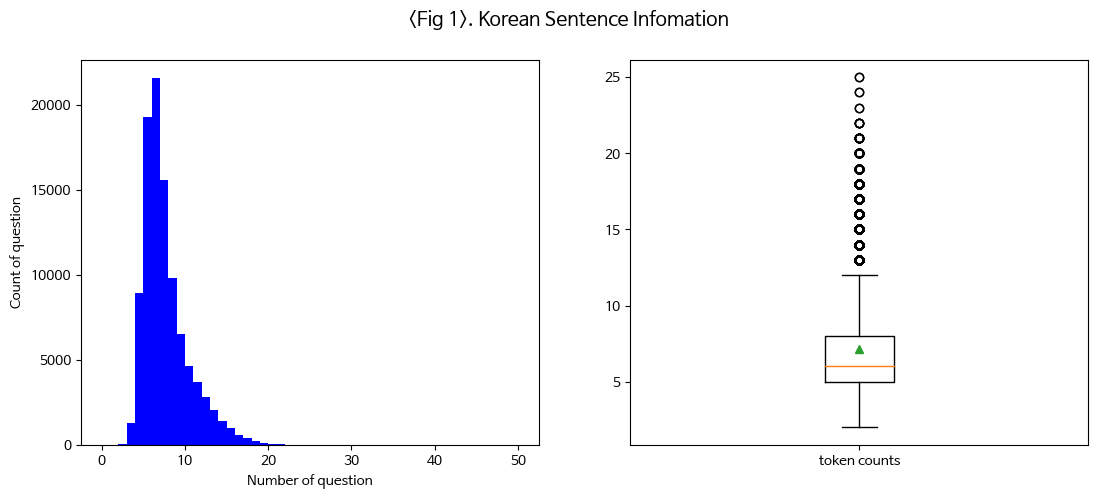

< Sentence Info >
길이 최대:      25
길이 최소:       2
길이 평균:      7.174
길이 표준편차:   2.740

 25/100분위:    5.000
 50/100분위:    6.000
 75/100분위:    8.000
 MAX/100분위:  12.500
 IQR:   3.000


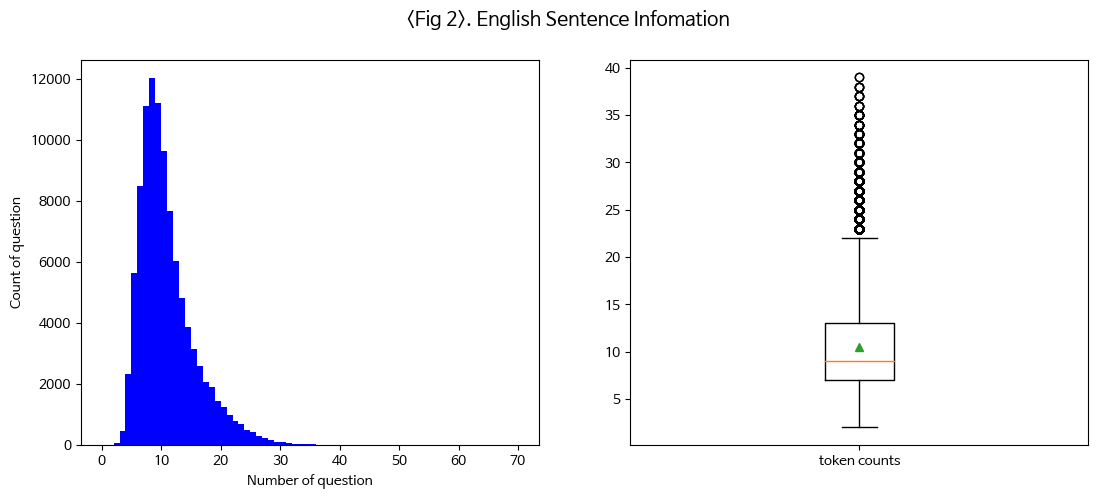

< Sentence Info >
길이 최대:      39
길이 최소:       2
길이 평균:     10.474
길이 표준편차:   4.655

 25/100분위:    7.000
 50/100분위:    9.000
 75/100분위:   13.000
 MAX/100분위:  22.000
 IQR:   6.000


In [9]:
kor_counts = [len(text.split()) for text in dataset["kor"]]
eng_counts = [len(text.split()) for text in dataset["eng"]]

show_sentence_length(kor_counts, "<Fig 1>. Korean Sentence Infomation", [0, 50])
show_sentence_length(eng_counts, "<Fig 2>. English Sentence Infomation", [0, 70])

<br>

## Data Preprocess


#### 문장 길이 기준 데이터 필터링

In [10]:
def filt_sentence_length(df, col, sentence_len):
    df = df.copy()
    df["len"] = df[col].apply(lambda x: len(x.split()))
    df = df.loc[df["len"] < sentence_len]
    df.drop(["len"], axis="columns", inplace=True)
    return df

dataset = filt_sentence_length(dataset, "kor", 13)
dataset = filt_sentence_length(dataset, "eng", 22)

In [11]:
len(dataset)

93097

<br>

### 정규식으로 데이터 전처리 + Decoder 입력 데이터에 토큰 추가 전처리


In [13]:
#전처리 함수
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Zㄱ-ㅎ가-힣0-9?.!,]+", " ", sentence)
    sentence = sentence.strip()
    return sentence


def preprocess_with_token(sentence, decoder_data=False):
    sentence = preprocess_sentence(sentence)

    if decoder_data:   #decoder
        sentence = "<sos> " + sentence + " <eos>"
    return sentence


In [14]:
dataset["kor"] = dataset["kor"].apply(preprocess_sentence)
dataset["eng"] = dataset["eng"].apply(lambda x: preprocess_with_token(x, True))

In [15]:
dataset.sample(30)

,kor,eng
286,window에 있는 것과 같은 것을 보여주세요 .,<sos> please show me the same on which is in w...
31431,그들은 예전에 다른 브랜드의 케이블을 사용했었습니다 .,<sos> they used a cable of a different brand i...
78542,너의 한국 주소를 알려 주면 매주 편지 쓸게 .,"<sos> if you tell me your korea address , i wi..."
57595,나는 잠시 후에 도서관에 갈 거야 .,<sos> i will go to the library soon . <eos>
13954,공장 모드로 해도 계속 꺼져요 .,<sos> it still turns off in factory mode . <eos>
75308,내일 오후 일정에 대해선 내일 아침에 알 수 있을 것 같아요 .,<sos> i ll be able to know my afternoon schedu...
93009,당신이 감성적인 날 싫어 할 것 같아서 불안해요 .,<sos> i am anxious that you might not like the...
15553,국민건강증진법 제9조 금연 시설 및 금연구역 기준에 의거 흡연을 금합니다 .,<sos> smoking is prohibited according to artic...
23647,그녀가 저를 어떻게 생각하는지 궁금해요 .,<sos> i wonder what she thinks of me . <eos>
56966,나는 이번 학기 졸업하면 뷔페 일을 합니다 .,<sos> i will work at a buffet when i graduate ...


### tokenize 함수


In [30]:

def tokenize(corpus, vocab_size, maxlen, encoder_TF=True):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        filters='',
        oov_token="<UNK>",
        num_words=vocab_size
    )
    corpus_input = corpus

    if encoder_TF:   # encoder data는 '한국어'이므로 mecab 형태소 분석
        m = MeCab()
        corpus_input = []
        for sentence in corpus:
            corpus_input.append(m.morphs(sentence))

    tokenizer.fit_on_texts(corpus_input)

    if vocab_size is not None:
        words_frequency = [w for w, c in tokenizer.word_index.items() if c >= vocab_size + 1]
        for w in words_frequency:
            del tokenizer.word_index[w]
            del tokenizer.word_counts[w]

    tensor = tokenizer.texts_to_sequences(corpus_input)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(
        tensor,
        padding='post',
        maxlen=maxlen
    )

    # 토큰 수 통계 출력
    token_lengths = [len(tokens) for tokens in tensor]
    max_tokens = max(token_lengths)

    print(f"Maximum tokens: {max_tokens}")

    return tensor, tokenizer


In [31]:
enc_tensor, enc_tokenizer = tokenize(dataset["kor"], None, None, encoder_TF=True)
dec_tensor, dec_tokenizer = tokenize(dataset["eng"], None, None, encoder_TF=False)

print("Korean Vocab Size:", f"{len(enc_tokenizer.word_index):,}")
print("English Vocab Size:", f"{len(dec_tokenizer.word_index):,}")

Maximum tokens: 37
Maximum tokens: 33
Korean Vocab Size: 28,895
English Vocab Size: 24,135


In [32]:
enc_tensor, enc_tokenizer = tokenize(dataset["kor"], 28895, 37, encoder_TF=True)
dec_tensor, dec_tokenizer = tokenize(dataset["eng"], 24135, 33, encoder_TF=False)


Maximum tokens: 37
Maximum tokens: 33


<br>

## 모델 설계 및 학습


#### 모델 설계


In [33]:
#Attention
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)

    def call(self, h_enc, h_dec):
        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))

        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn


#인코더
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()

        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(
            enc_units,
            dropout=0.2,
            return_sequences=True
        )

    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)

        return out


#디코더
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(
            dec_units,
            dropout=0.2,
            return_sequences=True,
            return_state=True
        )
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)

        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn



SRC_VOCAB_SIZE = len(enc_tokenizer.word_index) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.word_index) + 1

units = 256
embedding_dim = 256



In [34]:
encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

<br>

#### 학습 하이퍼파리미터 설정



In [36]:

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none'
)



<br>

#### 모델 학습 함수 설정

In [37]:

#손실 함수
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask

    return tf.reduce_mean(loss)



#학습 함수
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]

        dec_src = tf.expand_dims([dec_tok.word_index['<sos>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)

    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss




#### 모델 학습

In [38]:

EPOCHS = 10
BATCH_SIZE = 64


for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_tensor.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_tensor[idx:idx+BATCH_SIZE],
                                dec_tensor[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

Epoch 10: 100%|██████████| 1455/1455 [02:10<00:00, 11.18it/s, Loss 1.6413]


<br>

## 모델 평가


- 학습된 모델에 한국어 문장을 입력하여 모델이 출력한 번역 결과를 확인
- 변역 문장과 함께 Attention Matrix를 시각화하여 문장이 올바르게 학습 되었는지 확인


#### 모델 평가를 위한 함수 생성


In [26]:
# 번역
def evaluate(sentence, encoder, decoder):
    m = MeCab()

    attention = np.zeros((dec_tensor.shape[-1], enc_tensor.shape[-1]))

    sentence = preprocess_sentence(sentence)
    sentence = m.morphs(sentence)

    inputs = enc_tokenizer.texts_to_sequences([sentence])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(
        inputs,
        maxlen=enc_tensor.shape[-1],
        padding='post'
    )

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<sos>']], 0)

    for t in range(dec_tensor.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<eos>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention



#Matrix 생성 함수
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


#번역 및 시각화 함수
def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention = attention[:len(result.split()), :len(sentence)]
    plot_attention(attention, sentence, result.split(' '))
    return(result)


<br>

#### 모델 평가


<ipython-input-26-5b4d66de864f>:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)


Input: ['아버지', '가', '방', '에', '들어가', '신다', '.']
Predicted translation: he is a car . <eos> 


<ipython-input-26-5b4d66de864f>:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


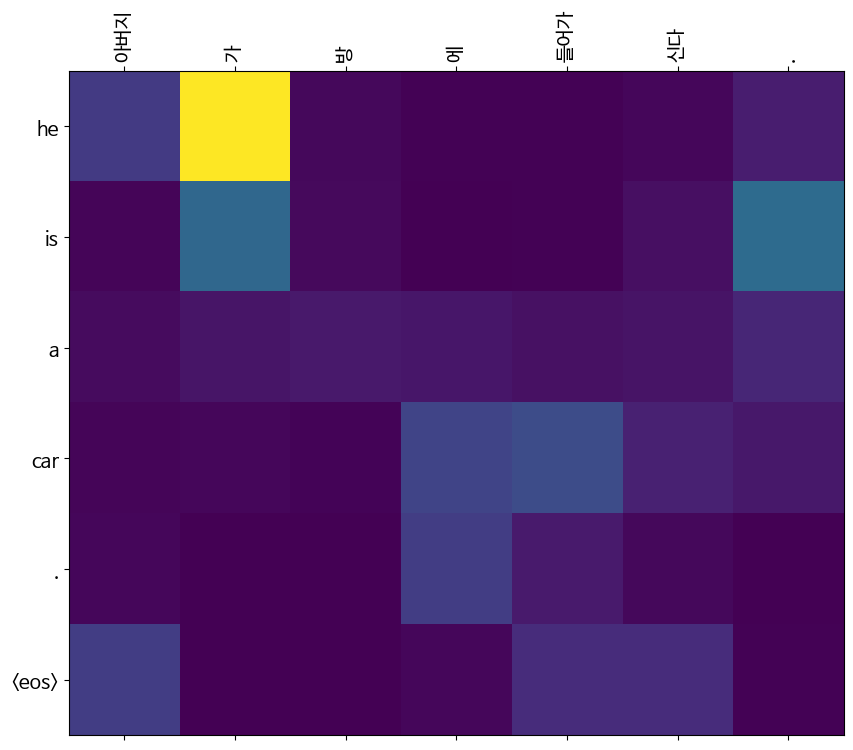


Input: ['저', '는', '지금', '공부', '를', '하', '고', '있', '어요', '.']
Predicted translation: i m going to sleep now . <eos> 


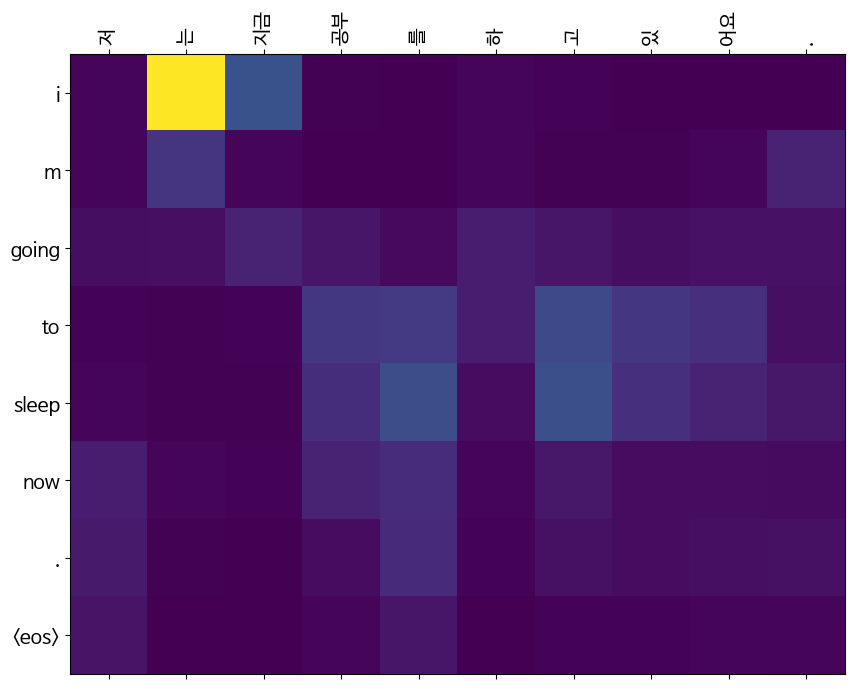


Input: ['비', '가', '올', '수', '있', '으니', '꼭', '우산', '을', '챙기', '세요', '.']
Predicted translation: please let me know if you come to the hotel . <eos> 


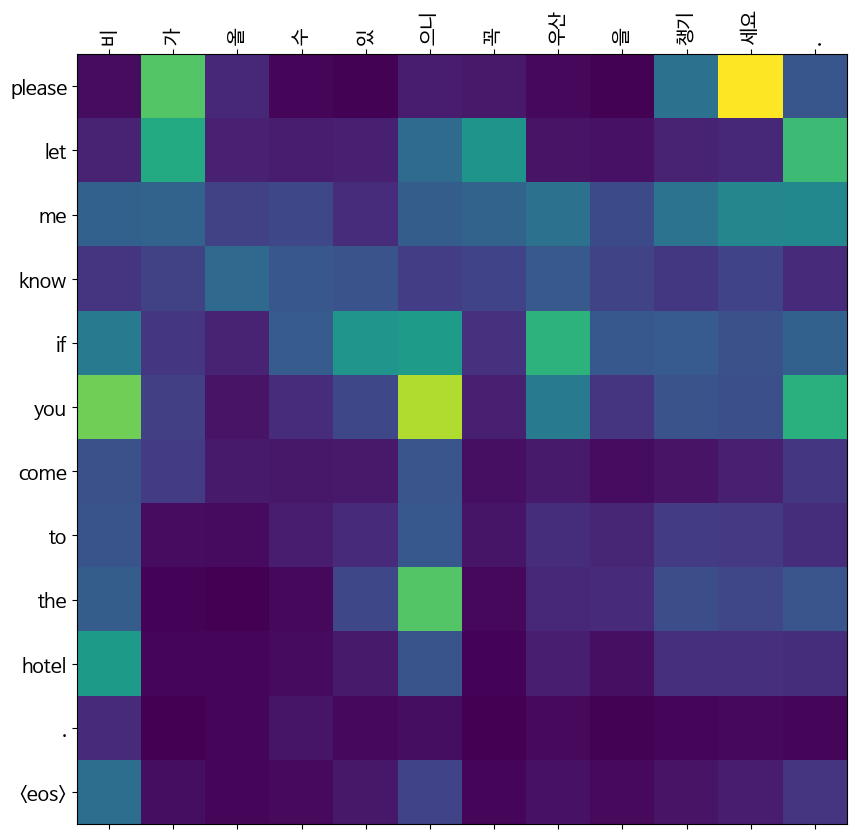


Input: ['컴퓨터', '가', '고장났', '어요', '.']
Predicted translation: the second floor is the public . <eos> 


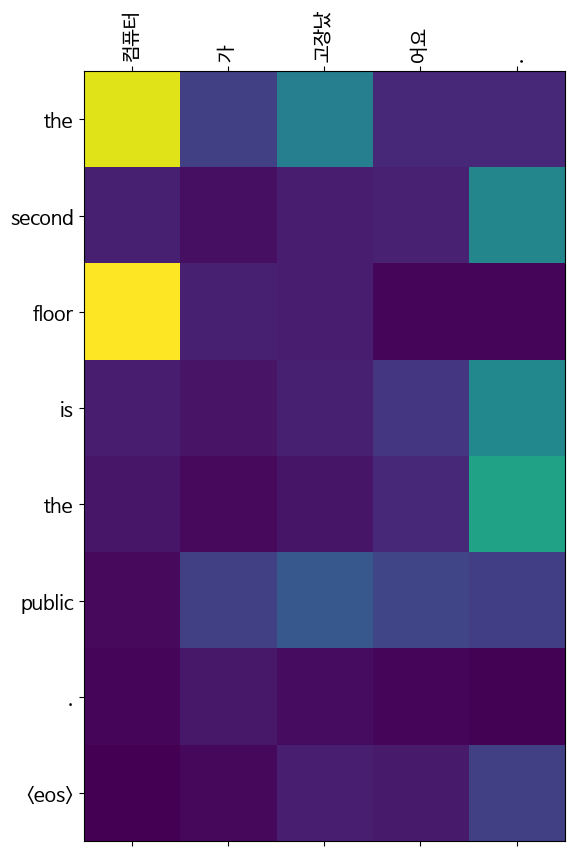


Input: ['저희', '내일', '저녁', '7', '시', '에', '만날', '래요', '?']
Predicted translation: are you going to go to the airport tomorrow ? <eos> 


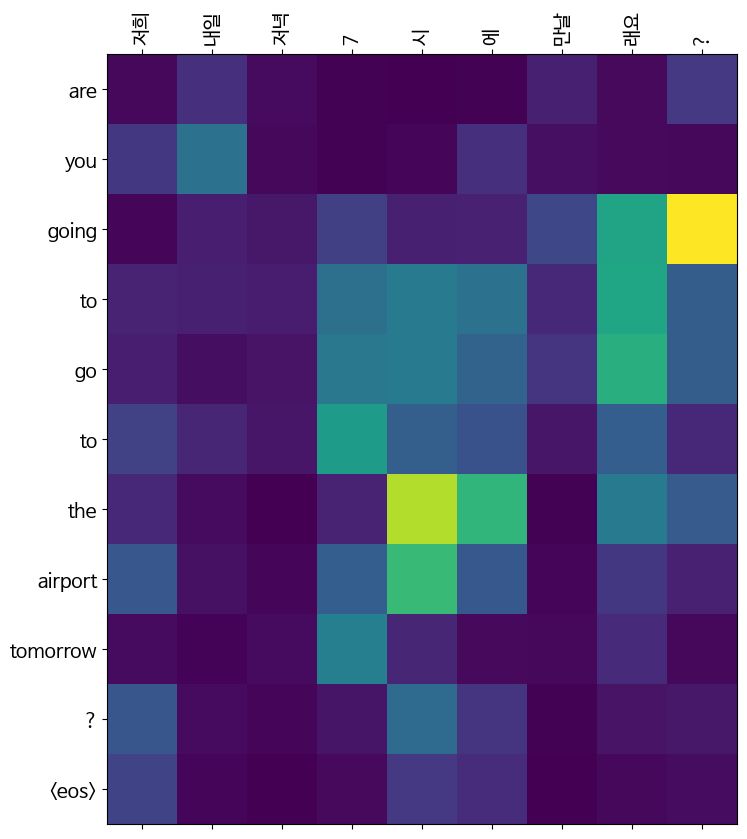


Input: ['현재', '날씨', '는', '28', '도', '입니다', '.']
Predicted translation: the second is a little bit . <eos> 


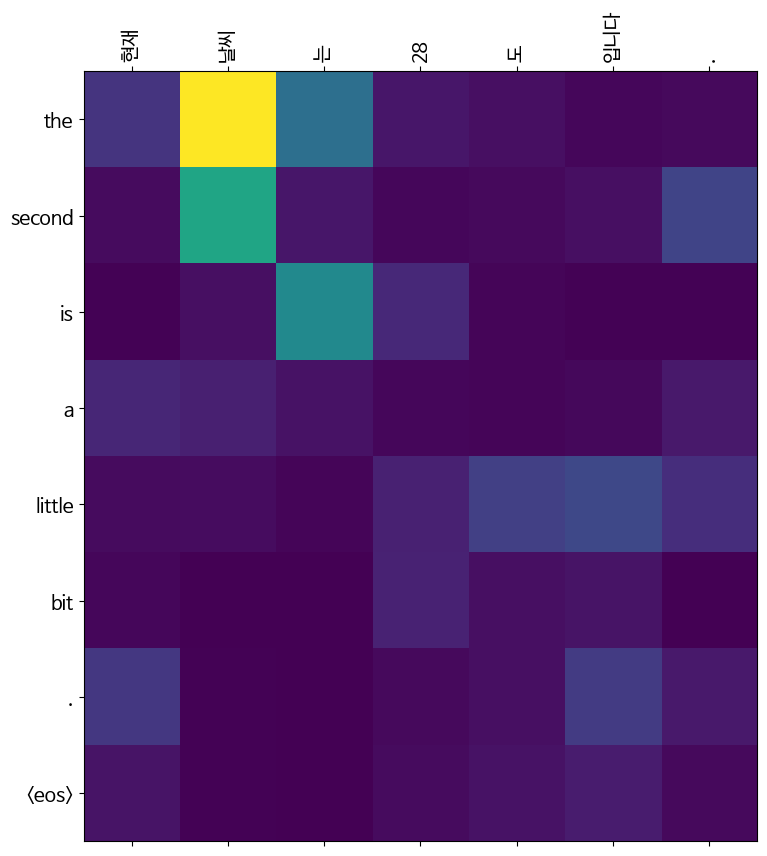


Input: ['당신', '을', '정말', '사랑', '해요', '.']
Predicted translation: i m really good at me . <eos> 


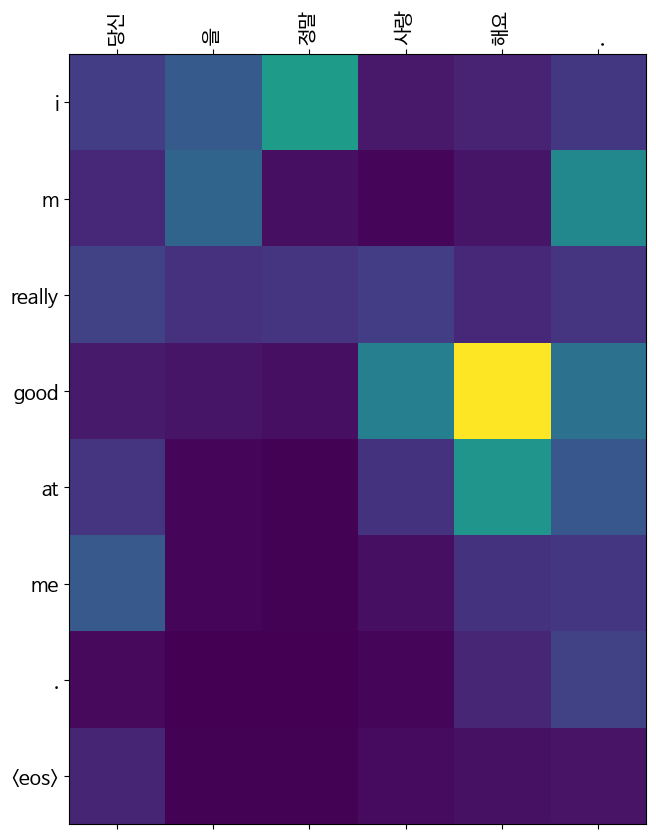


Input: ['저', '는', '음악', '을', '들으면서', '산책', '하', '는', '것', '을', '좋', '아', '해요', '.']
Predicted translation: i like to listen to music and i like . <eos> 


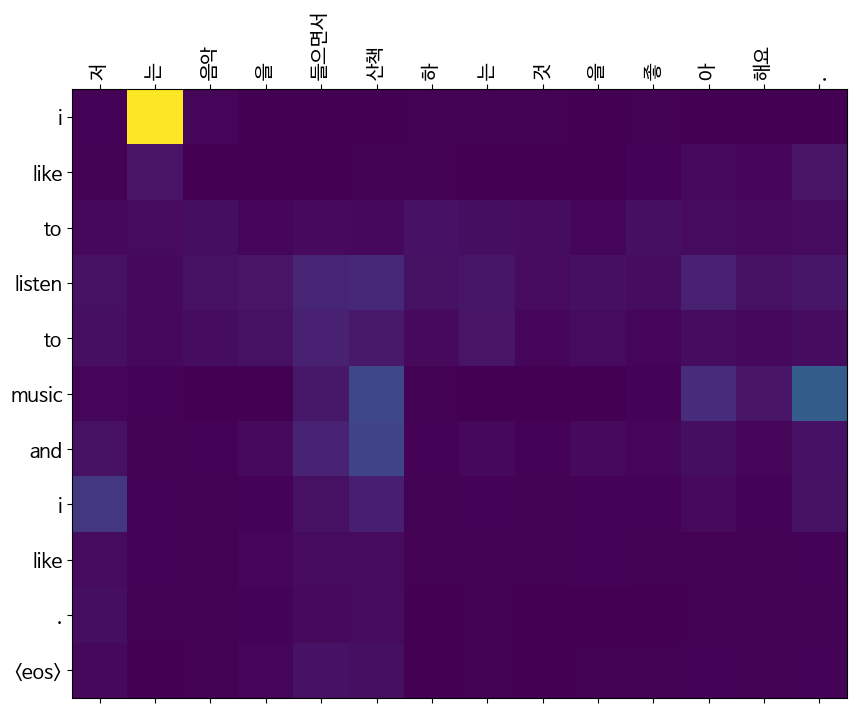


Input: ['최근', '에', '재밌', '게', '본', '영화', '가', '있', '나요', '?']
Predicted translation: did you have a good time with my friend ? <eos> 


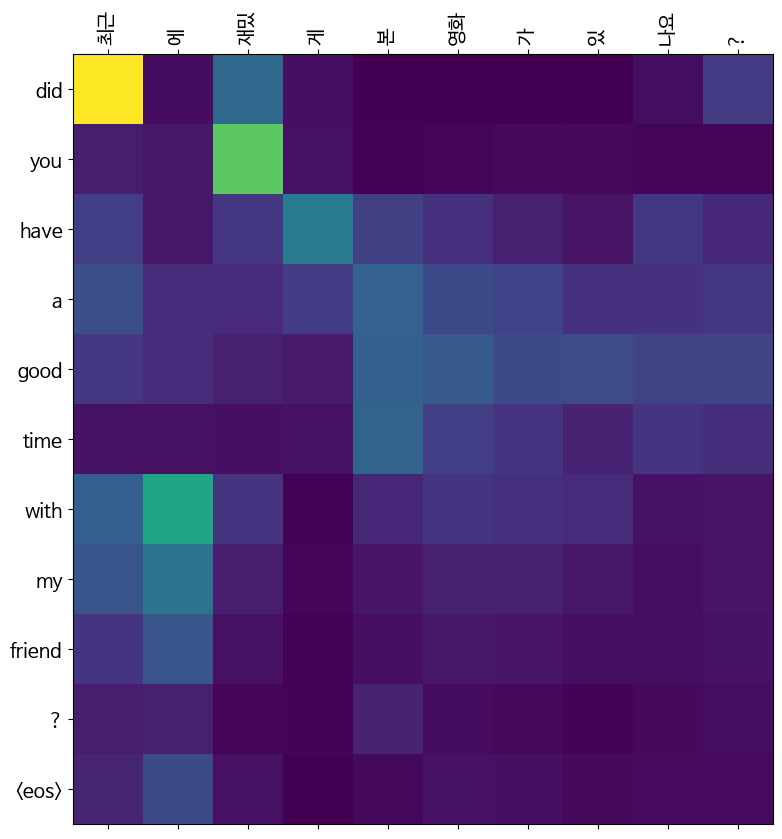


Input: ['여행', '가', '고', '싶', '어요', '.']
Predicted translation: i want to go to korea . <eos> 


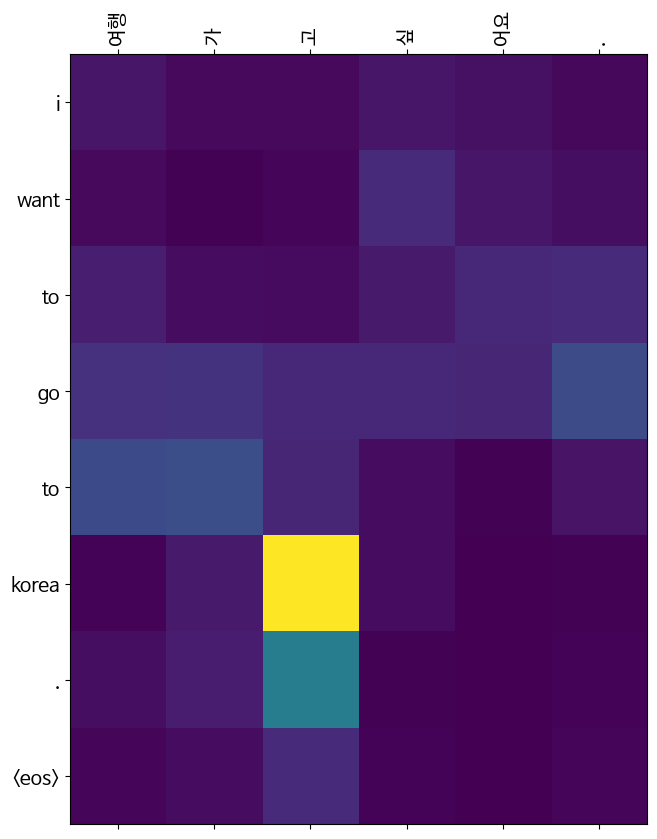

In [42]:
sentences = [
    "아버지가 방에 들어가신다.",
    "저는 지금 공부를 하고 있어요.",
    "비가 올 수 있으니 꼭 우산을 챙기세요.",
    "컴퓨터가 고장났어요.",
    "저희 내일 저녁 7시에 만날래요?",
    "현재 날씨는 28도 입니다.",
    "당신을 정말 사랑해요.",
    "저는 음악을 들으면서 산책하는 것을 좋아해요.",
    "최근에 재밌게 본 영화가 있나요?",
    "여행 가고 싶어요."
]

for sentence in sentences:
    translate(sentence, encoder, decoder)
    print()

In [43]:
# 번역 결과와 원래 문장을 저장할 리스트
translations = []
original_sentences = []

# 주어진 문장들 순회하며 번역 및 결과 저장
for sentence in sentences:
    result, _, _ = evaluate(sentence, encoder, decoder)
    translations.append(result)
    original_sentences.append(sentence)

# 데이터 프레임 생성
df = pd.DataFrame({
    'Original Sentence': original_sentences,
    'Translation': translations
})

# 데이터 프레임 출력
display(df)

,Original Sentence,Translation
0,아버지가 방에 들어가신다.,he is a car . <eos>
1,저는 지금 공부를 하고 있어요.,i m going to sleep now . <eos>
2,비가 올 수 있으니 꼭 우산을 챙기세요.,please let me know if you come to the hotel . ...
3,컴퓨터가 고장났어요.,the second floor is the public . <eos>
4,저희 내일 저녁 7시에 만날래요?,are you going to go to the airport tomorrow ? ...
5,현재 날씨는 28도 입니다.,the second is a little bit . <eos>
6,당신을 정말 사랑해요.,i m really good at me . <eos>
7,저는 음악을 들으면서 산책하는 것을 좋아해요.,i like to listen to music and i like . <eos>
8,최근에 재밌게 본 영화가 있나요?,did you have a good time with my friend ? <eos>
9,여행 가고 싶어요.,i want to go to korea . <eos>


## Trial + 10 epoch

In [44]:

EPOCHS = 10
BATCH_SIZE = 64


for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_tensor.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_tensor[idx:idx+BATCH_SIZE],
                                dec_tensor[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

Epoch 10: 100%|██████████| 1455/1455 [02:10<00:00, 11.17it/s, Loss 0.8077]


<br>

#### 모델 평가


<ipython-input-26-5b4d66de864f>:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)


Input: ['아버지', '가', '방', '에', '들어가', '신다', '.']
Predicted translation: i am on my room . <eos> 


<ipython-input-26-5b4d66de864f>:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


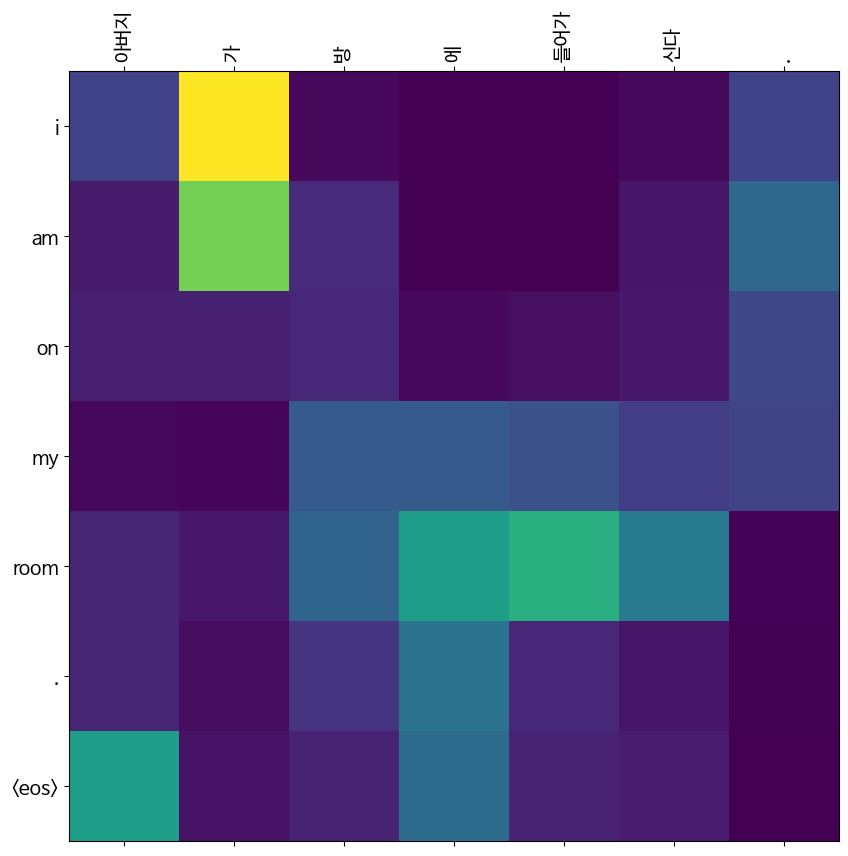


Input: ['저', '는', '지금', '공부', '를', '하', '고', '있', '어요', '.']
Predicted translation: i m studying hard . <eos> 


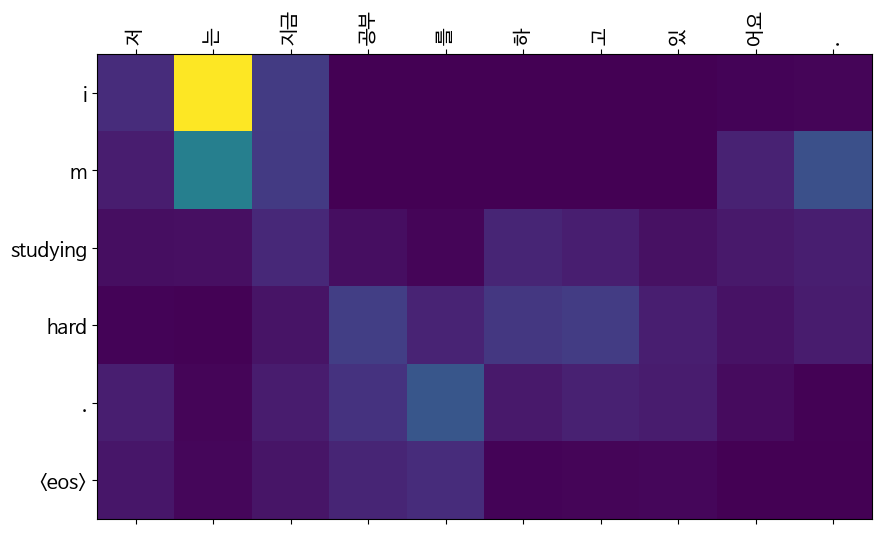


Input: ['비', '가', '올', '수', '있', '으니', '꼭', '우산', '을', '챙기', '세요', '.']
Predicted translation: call me if you can get off . <eos> 


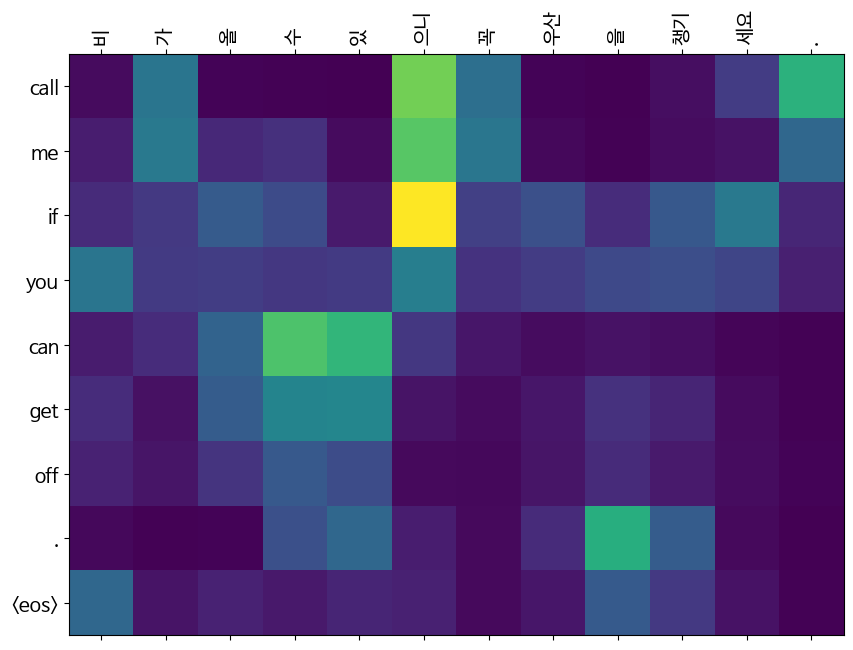


Input: ['컴퓨터', '가', '고장났', '어요', '.']
Predicted translation: use the use of the computer . <eos> 


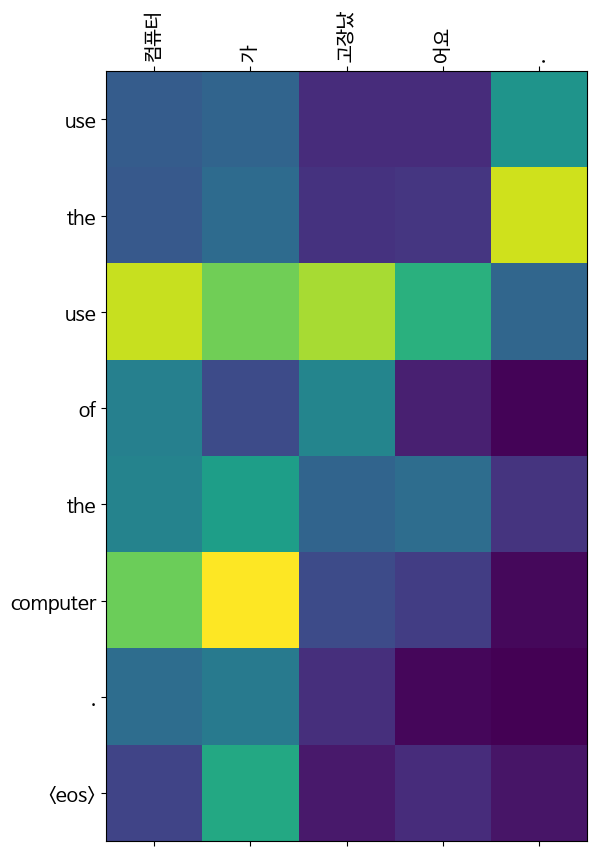


Input: ['저희', '내일', '저녁', '7', '시', '에', '만날', '래요', '?']
Predicted translation: is it possible to meet tomorrow evening ? <eos> 


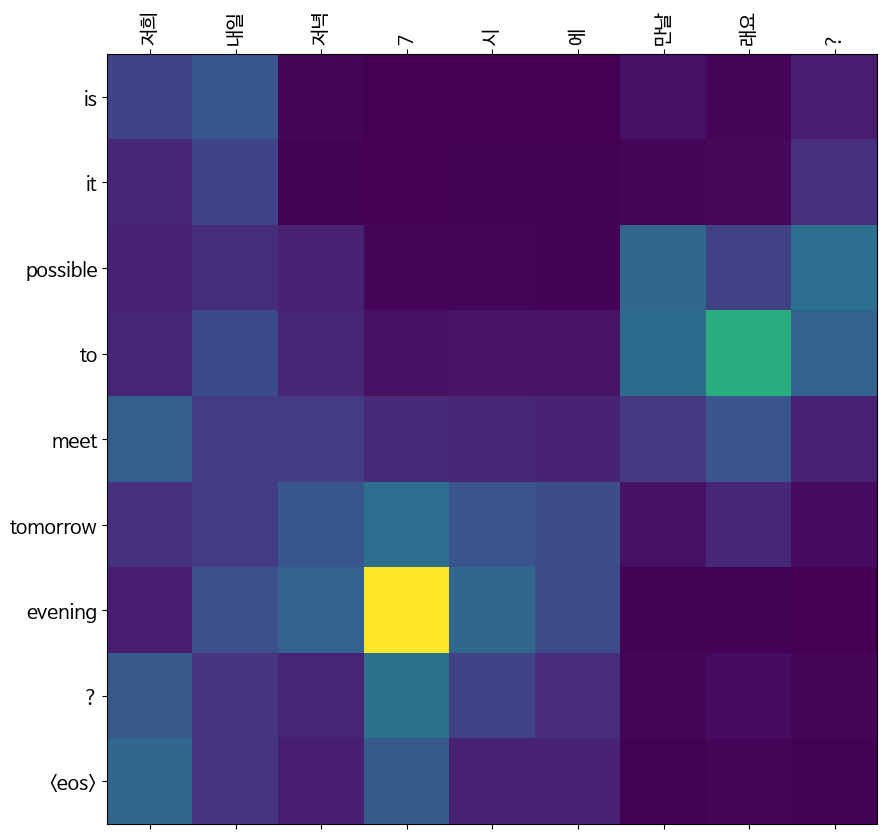


Input: ['현재', '날씨', '는', '28', '도', '입니다', '.']
Predicted translation: the weather is a new year s . <eos> 


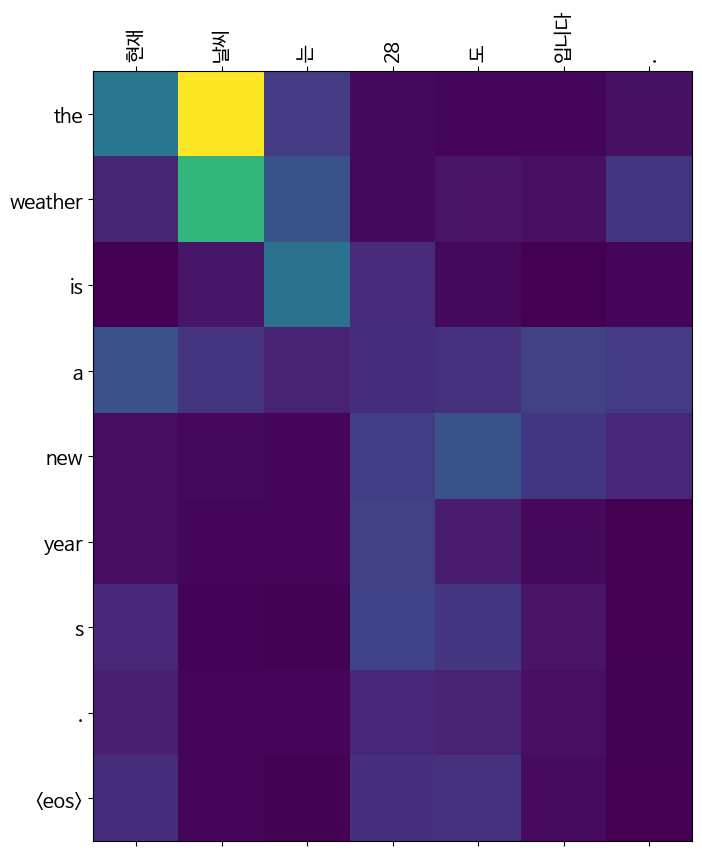


Input: ['당신', '을', '정말', '사랑', '해요', '.']
Predicted translation: i love you . <eos> 


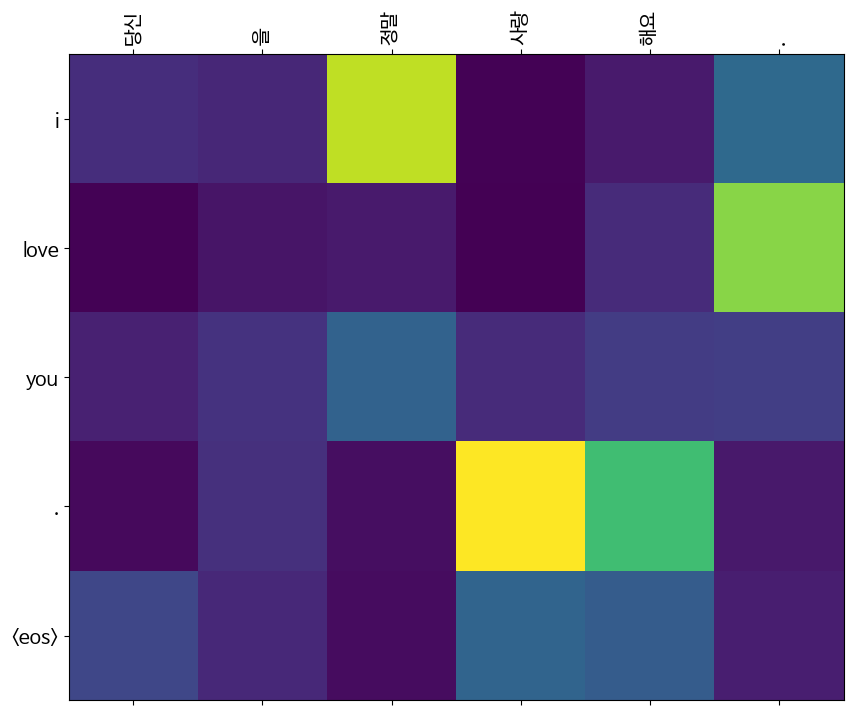


Input: ['저', '는', '음악', '을', '들으면서', '산책', '하', '는', '것', '을', '좋', '아', '해요', '.']
Predicted translation: i like to watch a movie and play golf . <eos> 


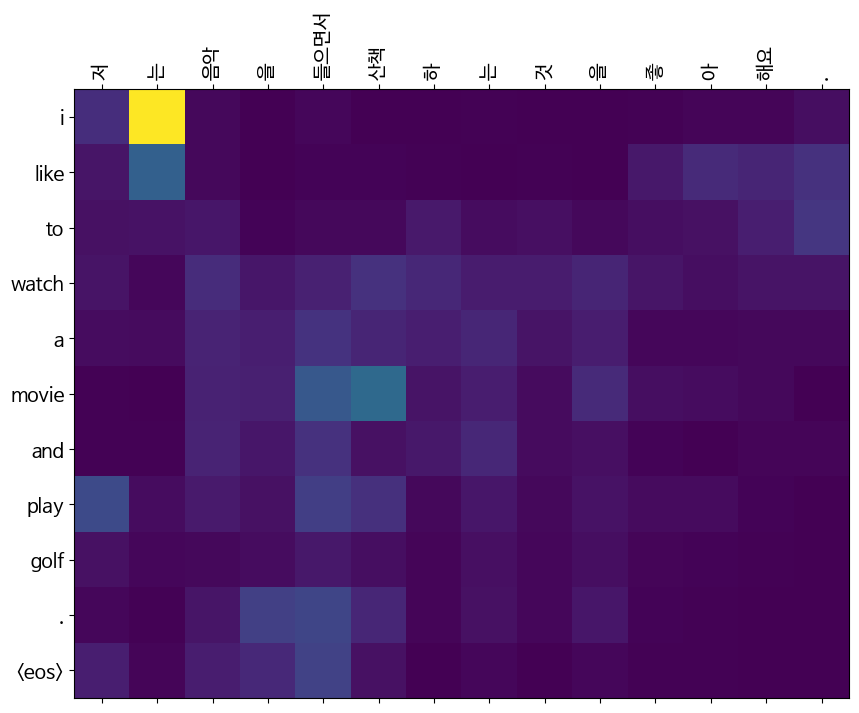


Input: ['최근', '에', '재밌', '게', '본', '영화', '가', '있', '나요', '?']
Predicted translation: is there a movie that movie in the movie ? <eos> 


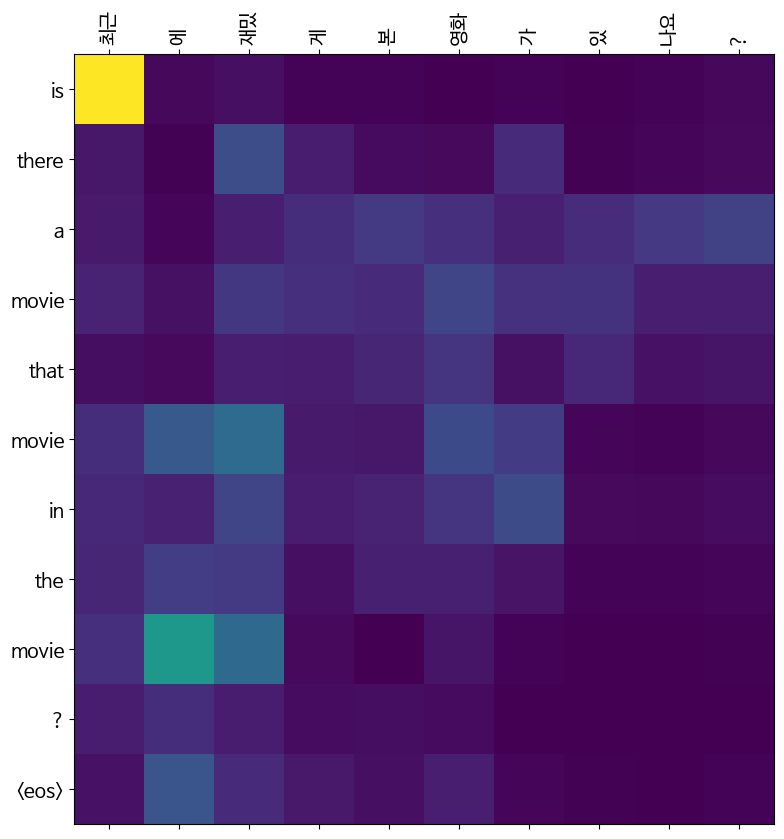


Input: ['여행', '가', '고', '싶', '어요', '.']
Predicted translation: i want to go to thailand . <eos> 


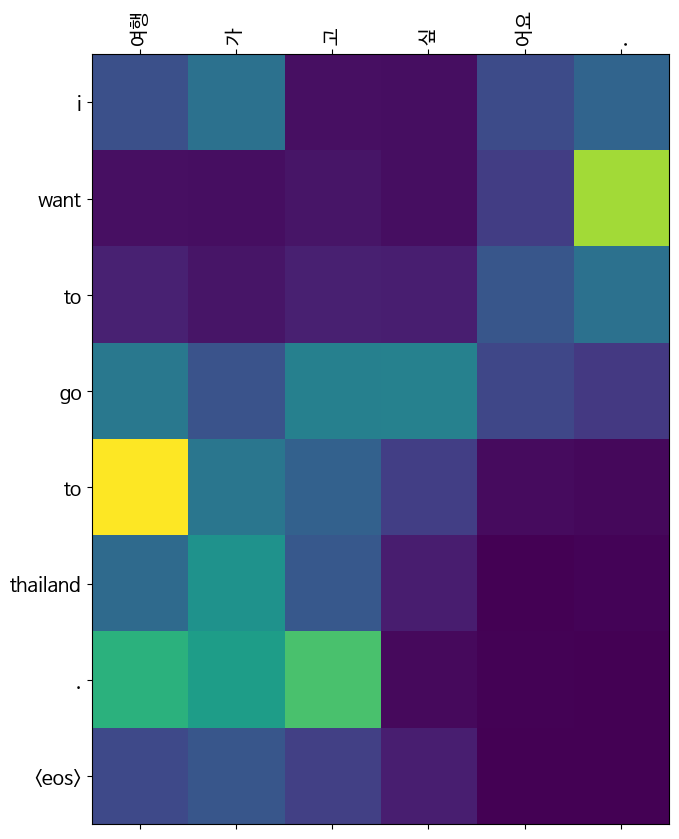

In [45]:
sentences = [
    "아버지가 방에 들어가신다.",
    "저는 지금 공부를 하고 있어요.",
    "비가 올 수 있으니 꼭 우산을 챙기세요.",
    "컴퓨터가 고장났어요.",
    "저희 내일 저녁 7시에 만날래요?",
    "현재 날씨는 28도 입니다.",
    "당신을 정말 사랑해요.",
    "저는 음악을 들으면서 산책하는 것을 좋아해요.",
    "최근에 재밌게 본 영화가 있나요?",
    "여행 가고 싶어요."
]

for sentence in sentences:
    translate(sentence, encoder, decoder)
    print()

In [46]:
# 번역 결과와 원래 문장을 저장할 리스트
translations = []
original_sentences = []

# 주어진 문장들 순회하며 번역 및 결과 저장
for sentence in sentences:
    result, _, _ = evaluate(sentence, encoder, decoder)
    translations.append(result)
    original_sentences.append(sentence)

# 데이터 프레임 생성
df = pd.DataFrame({
    'Original Sentence': original_sentences,
    'Translation': translations
})

# 데이터 프레임 출력
display(df)

,Original Sentence,Translation
0,아버지가 방에 들어가신다.,i am on my room . <eos>
1,저는 지금 공부를 하고 있어요.,i m studying hard . <eos>
2,비가 올 수 있으니 꼭 우산을 챙기세요.,call me if you can get off . <eos>
3,컴퓨터가 고장났어요.,use the use of the computer . <eos>
4,저희 내일 저녁 7시에 만날래요?,is it possible to meet tomorrow evening ? <eos>
5,현재 날씨는 28도 입니다.,the weather is a new year s . <eos>
6,당신을 정말 사랑해요.,i love you . <eos>
7,저는 음악을 들으면서 산책하는 것을 좋아해요.,i like to watch a movie and play golf . <eos>
8,최근에 재밌게 본 영화가 있나요?,is there a movie that movie in the movie ? <eos>
9,여행 가고 싶어요.,i want to go to thailand . <eos>
